In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


In [2]:
def plot_path(cart_path,target,xlim=[-5,5],ylim=[-5,5]):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


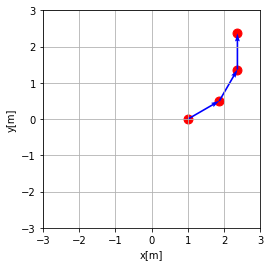

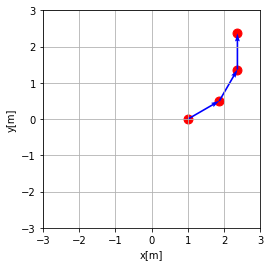

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes,[-3,3],[-3,3])

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_MAX_TRANS_VEL = 0.5 # [m/s]
DATA_MAX_ROTATE_VEL = 2*xp.pi # [rad/s]
DATA_M_PER_STEP = DATA_MAX_TRANS_VEL / DATA_HZ # [m/step]
DATA_RAD_PER_STEP = DATA_MAX_ROTATE_VEL / DATA_HZ # [rad/step]

print('DATA_SIZE          :',DATA_SIZE)
print('DATA_NUM_WAYPOINTS :',DATA_NUM_WAYPOINTS)
print('DATA_NUM_STEP      :',DATA_NUM_STEP)
print('DATA_HZ            :',DATA_HZ) 
print('DATA_MAX_TRANS_VEL :',DATA_MAX_TRANS_VEL)
print('DATA_MAX_ROTATE_VEL:',DATA_MAX_ROTATE_VEL)
print('DATA_M_PER_STEP    :',DATA_M_PER_STEP)
print('DATA_RAD_PER_STEP  :', DATA_RAD_PER_STEP)

X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP)
    d_rotate = data.rotate_path(d,rand_rad/2)
    #d_xy_fl = xp.ravel(d_xy[0:DATA_WAYPOINTS])
    X_train.append(d_rotate)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

DATA_SIZE          : 1000
DATA_NUM_WAYPOINTS : 10
DATA_NUM_STEP      : 10
DATA_HZ            : 10
DATA_MAX_TRANS_VEL : 0.5
DATA_MAX_ROTATE_VEL: 6.283185307179586
DATA_M_PER_STEP    : 0.05
DATA_RAD_PER_STEP  : 0.6283185307179586
1000
(10, 3)


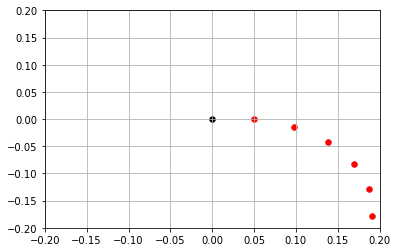

 -- x_train -- 
[[ 4.98121117e-02  5.10556950e-08 -2.02151735e+00]
 [ 9.73923834e-02 -1.47432259e-02 -2.32199735e+00]
 [ 1.38477102e-01 -4.29086721e-02 -2.62247735e+00]
 [ 1.69384628e-01 -8.19723552e-02 -2.92295735e+00]
 [ 1.87345308e-01 -1.28433742e-01 -3.22343735e+00]
 [ 1.90749668e-01 -1.78129383e-01 -3.52391735e+00]
 [ 1.79292642e-01 -2.26606007e-01 -3.82439735e+00]
 [ 1.54000903e-01 -2.69519576e-01 -4.12487735e+00]
 [ 1.17140869e-01 -3.03024566e-01 -4.42535735e+00]
 [ 7.20156015e-02 -3.24118563e-01 -4.72583735e+00]]


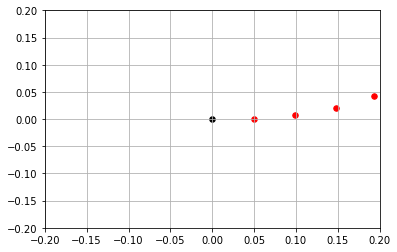

 -- x_train -- 
[[ 4.99572180e-02 -1.63827678e-07 -1.35581305e+00]
 [ 9.94022609e-02  7.13505631e-03 -1.21249305e+00]
 [ 1.47321234e-01  2.12593493e-02 -1.06917305e+00]
 [ 1.92731535e-01  4.20830895e-02 -9.25853047e-01]
 [ 2.34702005e-01  6.91792761e-02 -7.82533047e-01]
 [ 2.72372017e-01  1.01992289e-01 -6.39213047e-01]
 [ 3.04969131e-01  1.39849280e-01 -4.95893047e-01]
 [ 3.31824926e-01  1.81973975e-01 -3.52573047e-01]
 [ 3.52388712e-01  2.27502585e-01 -2.09253047e-01]
 [ 3.66238817e-01  2.75501525e-01 -6.59330474e-02]]


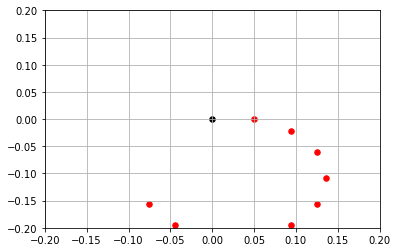

 -- x_train -- 
[[ 4.95807199e-02  4.80499459e-08 -2.24456730e+00]
 [ 9.42432254e-02 -2.15291970e-02 -2.69374730e+00]
 [ 1.25126785e-01 -6.03164824e-02 -3.14292730e+00]
 [ 1.36104316e-01 -1.08666680e-01 -3.59210730e+00]
 [ 1.24997952e-01 -1.56987446e-01 -4.04128730e+00]
 [ 9.40111174e-02 -1.95692277e-01 -4.49046730e+00]
 [ 4.92913864e-02 -2.17102402e-01 -4.93964730e+00]
 [-2.89157243e-04 -2.16970201e-01 -5.38882730e+00]
 [-4.48940780e-02 -1.95321902e-01 -5.83800730e+00]
 [-7.56740691e-02 -1.56452378e-01 -6.28718730e+00]]


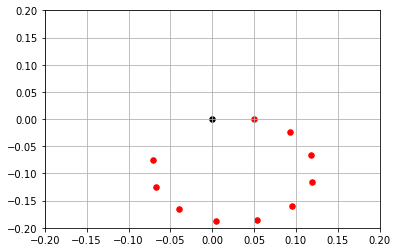

 -- x_train -- 
[[ 4.94471219e-02  1.55409720e-07 -2.34481447e+00]
 [ 9.24560489e-02 -2.43975915e-02 -2.86082447e+00]
 [ 1.17826811e-01 -6.68398146e-02 -3.37683447e+00]
 [ 1.18952598e-01 -1.16274119e-01 -3.89284447e+00]
 [ 9.55402446e-02 -1.59827300e-01 -4.40885447e+00]
 [ 5.36865692e-02 -1.86157657e-01 -4.92486447e+00]
 [ 4.29070302e-03 -1.88408493e-01 -5.44087447e+00]
 [-3.97841586e-02 -1.65993667e-01 -5.95688447e+00]
 [-6.70604648e-02 -1.24750231e-01 -6.47289447e+00]
 [-7.04351828e-02 -7.54184045e-02 -6.98890447e+00]]


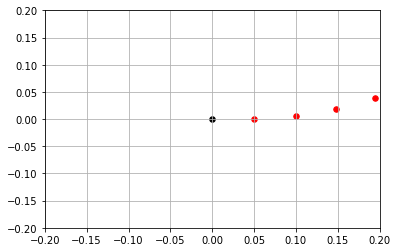

 -- x_train -- 
[[ 4.99649397e-02 -2.06140215e-07 -1.37618220e+00]
 [ 9.95099791e-02  6.46387009e-03 -1.24644220e+00]
 [ 1.47802322e-01  1.92835749e-02 -1.11670220e+00]
 [ 1.94030228e-01  3.82434235e-02 -9.86962201e-01]
 [ 2.37416660e-01  6.30247222e-02 -8.57222201e-01]
 [ 2.77232339e-01  9.32109256e-02 -7.27482201e-01]
 [ 3.12808010e-01  1.28294637e-01 -5.97742201e-01]
 [ 3.43545686e-01  1.67686140e-01 -4.68002201e-01]
 [ 3.68928700e-01  2.10723308e-01 -3.38262201e-01]
 [ 3.88530394e-01  2.56682733e-01 -2.08522201e-01]]


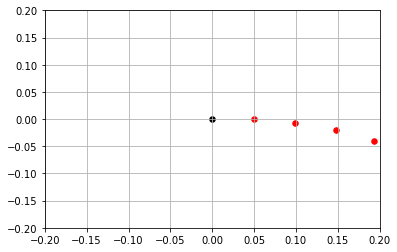

 -- x_train -- 
[[ 4.99601042e-02  9.67227893e-08 -1.77839826e+00]
 [ 9.94425031e-02 -6.89223307e-03 -1.91679826e+00]
 [ 1.47500895e-01 -2.05451804e-02 -2.05519826e+00]
 [ 1.93216211e-01 -4.06976463e-02 -2.19359826e+00]
 [ 2.35714192e-01 -6.69642349e-02 -2.33199826e+00]
 [ 2.74182105e-01 -9.88426238e-02 -2.47039826e+00]
 [ 3.07884290e-01 -1.35723171e-01 -2.60879826e+00]
 [ 3.36176226e-01 -1.76900571e-01 -2.74719826e+00]
 [ 3.58516859e-01 -2.21587350e-01 -2.88559826e+00]
 [ 3.74478946e-01 -2.68928915e-01 -3.02399826e+00]]


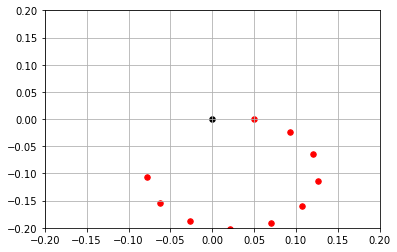

 -- x_train -- 
[[ 4.95043303e-02  2.08210869e-07 -2.30355053e+00]
 [ 9.32186232e-02 -2.32320822e-02 -2.79205053e+00]
 [ 1.20917039e-01 -6.42622719e-02 -3.28055053e+00]
 [ 1.26120244e-01 -1.13492399e-01 -3.76905053e+00]
 [ 1.07611079e-01 -1.59406335e-01 -4.25755053e+00]
 [ 6.97192920e-02 -1.91263692e-01 -4.74605053e+00]
 [ 2.13086946e-02 -2.01612256e-01 -5.23455053e+00]
 [-2.62962934e-02 -1.88031245e-01 -5.72305053e+00]
 [-6.19597041e-02 -1.53697591e-01 -6.21155053e+00]
 [-7.73389959e-02 -1.06642770e-01 -6.70005053e+00]]


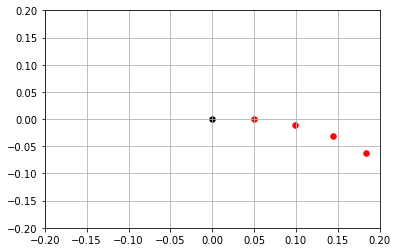

 -- x_train -- 
[[ 4.99034580e-02  6.02400109e-08 -1.89379253e+00]
 [ 9.86544553e-02 -1.06627438e-02 -2.10912253e+00]
 [ 1.44001275e-01 -3.14959170e-02 -2.32445253e+00]
 [ 1.83849431e-01 -6.15372143e-02 -2.53978253e+00]
 [ 2.16358413e-01 -9.93990844e-02 -2.75511253e+00]
 [ 2.40026692e-01 -1.43332758e-01 -2.97044253e+00]
 [ 2.53761074e-01 -1.91309022e-01 -3.18577253e+00]
 [ 2.56927193e-01 -2.41111942e-01 -3.40110253e+00]
 [ 2.49378813e-01 -2.90441214e-01 -3.61643253e+00]
 [ 2.31464580e-01 -3.37018412e-01 -3.83176253e+00]]


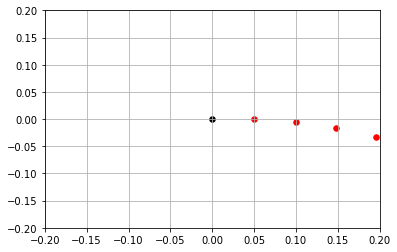

 -- x_train -- 
[[ 4.99731332e-02  1.69435019e-07 -1.74115472e+00]
 [ 9.96243515e-02 -5.66291836e-03 -1.85472472e+00]
 [ 1.48313934e-01 -1.69162985e-02 -1.96829472e+00]
 [ 1.95414551e-01 -3.36149793e-02 -2.08186472e+00]
 [ 2.40319344e-01 -5.55438101e-02 -2.19543472e+00]
 [ 2.82449747e-01 -8.24202535e-02 -2.30900472e+00]
 [ 3.21262939e-01 -1.13898026e-01 -2.42257472e+00]
 [ 3.56258841e-01 -1.49571558e-01 -2.53614472e+00]
 [ 3.86986554e-01 -1.88981223e-01 -2.64971472e+00]
 [ 4.13050175e-01 -2.31619254e-01 -2.76328472e+00]]


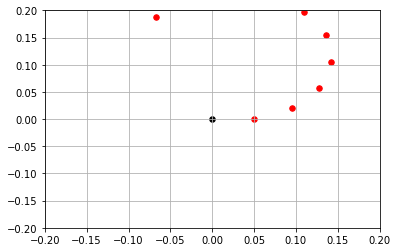

 -- x_train -- 
[[ 4.96241234e-02 -5.16379677e-08 -9.32935286e-01]
 [ 9.48287313e-02  2.04718084e-02 -5.07695286e-01]
 [ 1.27561956e-01  5.77691221e-02 -8.24552862e-02]
 [ 1.41993340e-01  1.05248473e-01  3.42784714e-01]
 [ 1.35552357e-01  1.54452816e-01  7.68024714e-01]
 [ 1.09386278e-01  1.96617849e-01  1.19326471e+00]
 [ 6.81558193e-02  2.24233114e-01  1.61850471e+00]
 [ 1.92049698e-02  2.32379767e-01  2.04374471e+00]
 [-2.87471203e-02  2.19606722e-01  2.46898471e+00]
 [-6.71592009e-02  1.88189121e-01  2.89422471e+00]]


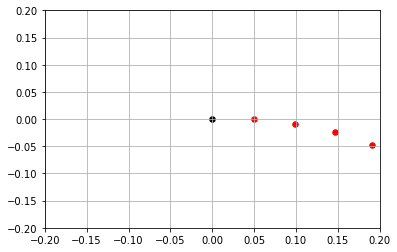

 -- x_train -- 
[[ 4.99433280e-02  1.03020461e-07 -1.81823839e+00]
 [ 9.92086885e-02 -8.20113280e-03 -1.98319839e+00]
 [ 1.46458520e-01 -2.43810427e-02 -2.14815839e+00]
 [ 1.90409981e-01 -4.81003396e-02 -2.31311839e+00]
 [ 2.29869784e-01 -7.87150411e-02 -2.47807839e+00]
 [ 2.63766589e-01 -1.15393953e-01 -2.64303839e+00]
 [ 2.91180093e-01 -1.57141239e-01 -2.80799839e+00]
 [ 3.11366015e-01 -2.02823451e-01 -2.97295839e+00]
 [ 3.23776304e-01 -2.51200313e-01 -3.13791839e+00]
 [ 3.28074019e-01 -3.00958384e-01 -3.30287839e+00]]


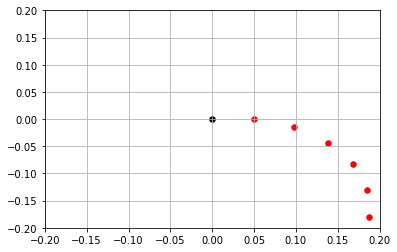

 -- x_train -- 
[[ 4.98053567e-02  2.01255552e-07 -2.02956037e+00]
 [ 9.72995250e-02 -1.49957159e-02 -2.33540037e+00]
 [ 1.38074511e-01 -4.35959614e-02 -2.64124037e+00]
 [ 1.68345938e-01 -8.31461105e-02 -2.94708037e+00]
 [ 1.85304275e-01 -1.29975464e-01 -3.25292037e+00]
 [ 1.87375599e-01 -1.79737730e-01 -3.55876037e+00]
 [ 1.74367666e-01 -2.27814411e-01 -3.86460037e+00]
 [ 1.47487761e-01 -2.69743449e-01 -4.17044037e+00]
 [ 1.09230640e-01 -3.01633358e-01 -4.47628037e+00]
 [ 6.31469948e-02 -3.20524393e-01 -4.78212037e+00]]


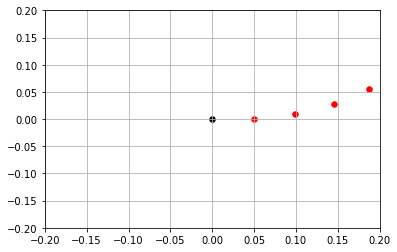

 -- x_train -- 
[[ 4.99252837e-02 -2.32266601e-07 -1.28666167e+00]
 [ 9.89576278e-02  9.39993637e-03 -1.09724167e+00]
 [ 1.45343009e-01  2.78642357e-02 -9.07821675e-01]
 [ 1.87422093e-01  5.47321464e-02 -7.18401675e-01]
 [ 2.23689594e-01  8.90425284e-02 -5.28981675e-01]
 [ 2.52848123e-01  1.29568004e-01 -3.39561675e-01]
 [ 2.73854597e-01  1.74858864e-01 -1.50141675e-01]
 [ 2.85957557e-01  2.23294928e-01  3.92783255e-02]
 [ 2.88724046e-01  2.73143504e-01  2.28698325e-01]
 [ 2.82055099e-01  3.22621368e-01  4.18118325e-01]]


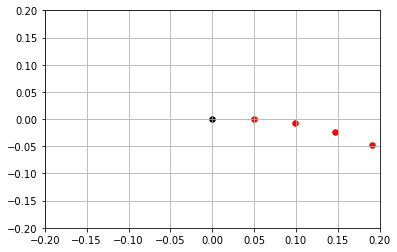

 -- x_train -- 
[[ 4.99459148e-02  6.23615557e-08 -1.81252258e+00]
 [ 9.92447111e-02 -8.01386855e-03 -1.97367258e+00]
 [ 1.46618901e-01 -2.38341264e-02 -2.13482258e+00]
 [ 1.90840868e-01 -4.70507581e-02 -2.29597258e+00]
 [ 2.30764683e-01 -7.70621471e-02 -2.45712258e+00]
 [ 2.65355791e-01 -1.13090603e-01 -2.61827258e+00]
 [ 2.93717827e-01 -1.54202515e-01 -2.77942258e+00]
 [ 3.15115842e-01 -1.99332542e-01 -2.94057258e+00]
 [ 3.28995345e-01 -2.47311223e-01 -3.10172258e+00]
 [ 3.34996674e-01 -2.96895277e-01 -3.26287258e+00]]


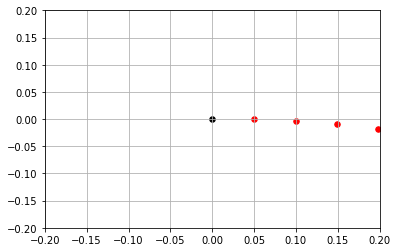

 -- x_train -- 
[[ 4.99917684e-02  4.60356097e-08 -1.66508725e+00]
 [ 9.98848039e-02 -3.14032146e-03 -1.72794725e+00]
 [ 1.49482025e-01 -9.40869780e-03 -1.79080725e+00]
 [ 1.98587519e-01 -1.87803224e-02 -1.85366725e+00]
 [ 2.47007316e-01 -3.12181766e-02 -1.91652725e+00]
 [ 2.94550153e-01 -4.66731299e-02 -1.97938725e+00]
 [ 3.41028232e-01 -6.50841340e-02 -2.04224725e+00]
 [ 3.86257961e-01 -8.63784640e-02 -2.10510725e+00]
 [ 4.30060679e-01 -1.10472006e-01 -2.16796725e+00]
 [ 4.72263363e-01 -1.37269588e-01 -2.23082725e+00]]


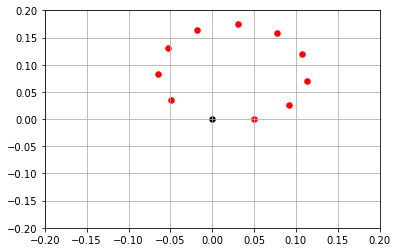

 -- x_train -- 
[[ 4.93510044e-02 -2.44161764e-07 -7.31946379e-01]
 [ 9.11841974e-02  2.61819176e-02 -1.72716379e-01]
 [ 1.12754166e-01  7.05695069e-02  3.86513621e-01]
 [ 1.07489139e-01  1.19638857e-01  9.45743621e-01]
 [ 7.69932243e-02  1.58439899e-01  1.50497362e+00]
 [ 3.05576807e-02  1.75151030e-01  2.06420362e+00]
 [-1.76698698e-02  1.64680835e-01  2.62343362e+00]
 [-5.29958309e-02  1.30219289e-01  3.18266362e+00]
 [-6.46573624e-02  8.22658713e-02  3.74189362e+00]
 [-4.91015192e-02  3.54306562e-02  4.30112362e+00]]


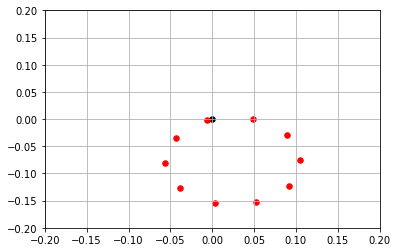

 -- x_train -- 
[[ 4.92025197e-02  9.96740264e-08 -2.50108335e+00]
 [ 8.92420159e-02 -2.85958211e-02 -3.12127335e+00]
 [ 1.05205221e-01 -7.51368140e-02 -3.74146335e+00]
 [ 9.11464180e-02 -1.22288039e-01 -4.36165335e+00]
 [ 5.23020029e-02 -1.52487366e-01 -4.98184335e+00]
 [ 3.14011871e-03 -1.54486636e-01 -5.60203335e+00]
 [-3.80282071e-02 -1.27541193e-01 -6.22222335e+00]
 [-5.58692588e-02 -8.16872421e-02 -6.84241335e+00]
 [-4.37378887e-02 -3.40037250e-02 -7.46260335e+00]
 [-6.15259419e-03 -2.25103093e-03 -8.08279335e+00]]


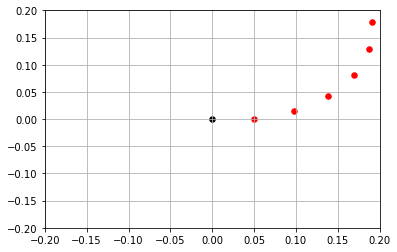

 -- x_train -- 
[[ 4.98126859e-02 -1.33843010e-07 -1.12076364e+00]
 [ 9.74003075e-02  1.47213453e-02 -8.20743640e-01]
 [ 1.38511442e-01  4.28492374e-02 -5.20723640e-01]
 [ 1.69473267e-01  8.18706293e-02 -2.20703640e-01]
 [ 1.87519691e-01  1.28299395e-01  7.93163601e-02]
 [ 1.91038466e-01  1.77987642e-01  3.79336360e-01]
 [ 1.79715228e-01  2.26496280e-01  6.79356360e-01]
 [ 1.54561584e-01  2.69491604e-01  9.79376360e-01]
 [ 1.17824730e-01  3.03132460e-01  1.27939636e+00]
 [ 7.27866939e-02  3.24413414e-01  1.57941636e+00]]


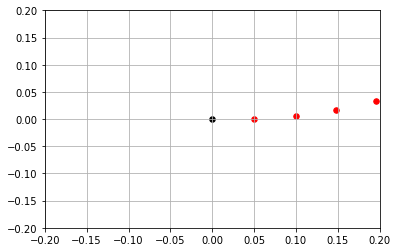

 -- x_train -- 
[[ 4.99729674e-02 -3.74130424e-08 -1.39991558e+00]
 [ 9.96220208e-02  5.68054028e-03 -1.28599558e+00]
 [ 1.48303523e-01  1.69680916e-02 -1.17207558e+00]
 [ 1.95386380e-01  3.37162876e-02 -1.05815558e+00]
 [ 2.40260221e-01  5.57080092e-02 -9.44235578e-01]
 [ 2.82343315e-01  8.26581613e-02 -8.30315578e-01]
 [ 3.21090106e-01  1.14217369e-01 -7.16395578e-01]
 [ 3.55998292e-01  1.49976508e-01 -6.02475578e-01]
 [ 3.86615333e-01  1.89472006e-01 -4.88555578e-01]
 [ 4.12544316e-01  2.32191852e-01 -3.74635578e-01]]


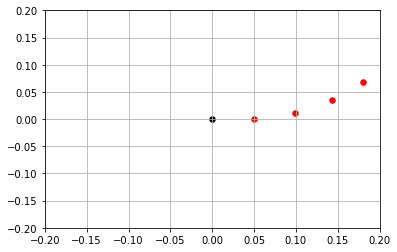

 -- x_train -- 
[[ 4.98815200e-02 -2.71476006e-08 -1.21295578e+00]
 [ 9.83503648e-02  1.17871319e-02 -9.74395783e-01]
 [ 1.42661187e-01  3.46938350e-02 -7.35835783e-01]
 [ 1.80304157e-01  6.74226126e-02 -4.97275783e-01]
 [ 2.09147120e-01  1.08119658e-01 -2.58715783e-01]
 [ 2.27556368e-01  1.54479831e-01 -2.01557826e-02]
 [ 2.34489175e-01  2.03877222e-01  2.18404217e-01]
 [ 2.29552855e-01  2.53513890e-01  4.56964217e-01]
 [ 2.13027010e-01  3.00578340e-01  6.95524217e-01]
 [ 1.85847688e-01  3.42404772e-01  9.34084217e-01]]


In [6]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    plt.xlim([-.2,.2])
    plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])

In [7]:
# loss
def error_squares(z_oplus,z_true, scale=DATA_M_PER_STEP):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p))) / scale
    return error

def error_limit_rotate_vel(predict,limit):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data < limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_limit_trans_vel(predict,limit):
    w = xp.array([1., 0., 0.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data <= limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_diff_v(y0, y1, scale=DATA_M_PER_STEP):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0)) / scale
    return error

def error_diff_w(y0, y1, scale=DATA_RAD_PER_STEP):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0)) / scale
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    # limit v
    e_lim_v = error_limit_trans_vel(y[0,0], DATA_M_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_v = e_lim_v + error_limit_trans_vel(y[0,i], DATA_M_PER_STEP)
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    # limit w
    e_lim_w = error_limit_rotate_vel(y[0,0], DATA_RAD_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_w = e_lim_w + error_limit_rotate_vel(y[0,i] , DATA_RAD_PER_STEP)
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_distance) + '\t'
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_distance) + '\t'
    '''
    loss = (1 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    #loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [ ]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y = model(x)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
            y_pad = F.concat((y,pad),axis=2)
            y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
            # loss
            loss = loss_function(y_pad, X[itr][:])
            model.cleargrads()
            loss.backward()
            opt.update()
            # y_grad = chainer.grad( (e,), (y,) )[0]
            # print(y_grad)
            # x_grad = chainer.grad( (e,), (x,) )[0]
            # print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    fig = plt.figure()
    plt.plot(range(len(AvgLoss)),AvgLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(AvgLoss)-1, AvgLoss[-1],str(AvgLoss[-1]),ha='center',va='top' )
    return model, fig

In [ ]:
EPOCH = 100
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
model, fig = train(model,X_train,epoch=EPOCH)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

Epoch: 1 , Average loss: 96.47787
Epoch: 2 , Average loss: 55.121216
Epoch: 3 , Average loss: 42.86549
Epoch: 4 , Average loss: 36.5125
Epoch: 5 , Average loss: 32.583046
Epoch: 6 , Average loss: 30.053202
Epoch: 7 , Average loss: 28.007074
Epoch: 8 , Average loss: 26.751005
Epoch: 9 , Average loss: 25.17082
Epoch: 10 , Average loss: 23.943909
Epoch: 11 , Average loss: 23.346048
Epoch: 12 , Average loss: 22.477983
Epoch: 13 , Average loss: 20.90218
Epoch: 14 , Average loss: 19.471794
Epoch: 15 , Average loss: 18.793404
Epoch: 16 , Average loss: 18.31403
Epoch: 17 , Average loss: 17.872675
Epoch: 18 , Average loss: 17.84687
Epoch: 19 , Average loss: 17.831226
Epoch: 20 , Average loss: 16.988234
Epoch: 21 , Average loss: 16.534678
Epoch: 22 , Average loss: 16.807926
Epoch: 23 , Average loss: 16.32344
Epoch: 24 , Average loss: 16.054047
Epoch: 25 , Average loss: 16.118385
Epoch: 26 , Average loss: 15.836724
Epoch: 27 , Average loss: 16.21092
Epoch: 28 , Average loss: 15.938053


In [ ]:
# log
def gen_filename():
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_M_PER_STEP * 1000))
    fn = 'Cart' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename()
os.mkdir(dirname)
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

In [ ]:
rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
x_test = data.generate_arc_path(DATA_NUM_WAYPOINTS,rand_rad,DATA_M_PER_STEP)
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y = model(x)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
y_pad = F.concat((y,pad),axis=2)
y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
print(xp.rad2deg(y_pad.data[:,:,2]))
# loss
z_true = x_test
z = y_pad[0,0]
print(' --- error --- ')
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
print(' --- trajectory --- ')
print(Z)
print(z_true.shape)
fig = plot_path(Z,z_true,[-.1,.4],[-.4,.4])
print(' --- grad --- ')
loss.backward()
y_grad = chainer.grad( (loss,), (y,) )[0]
print(y_grad)

In [ ]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    x_test = data.generate_arc_path(DATA_NUM_WAYPOINTS,rand_rad,DATA_M_PER_STEP)
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y = model(x)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
    y_pad = F.concat((y,pad),axis=2)
    y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    print(' --- trajectory --- ')
    print(Z)
    print(z_true.shape)
    fig = plot_path(Z,z_true,[-.1,.4],[-.4,.4])
    fig.savefig(dirname + '/test' + str(i) + '.png')